<a href="https://colab.research.google.com/github/mutai-star/sanitation-dashboard/blob/main/Image_segmentation_Asignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image segmentation task

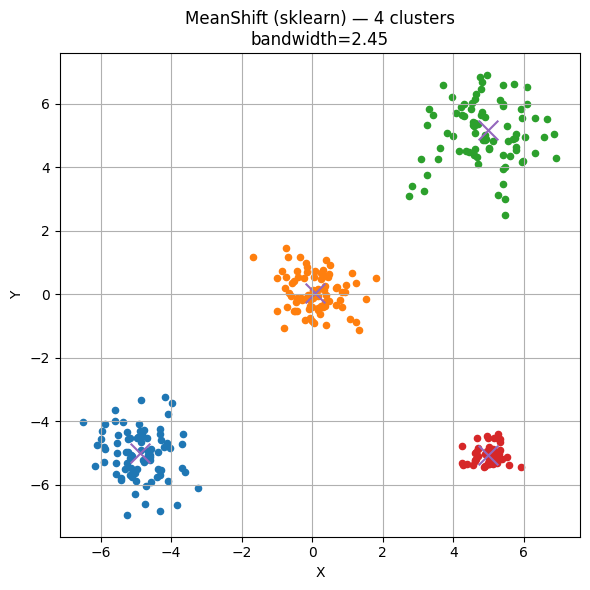

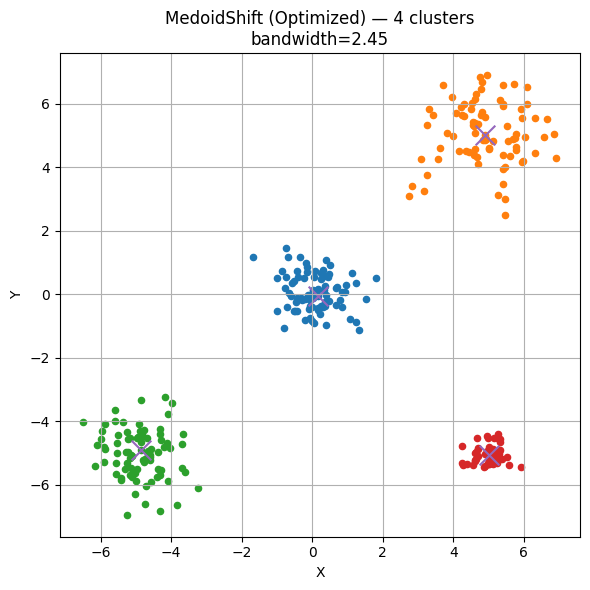


MeanShift found 4 clusters.
MedoidShift found 4 clusters.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances

# ------------------------------------------------------------
# 1. Generate synthetic data
# ------------------------------------------------------------
np.random.seed(1)

X1, _ = make_blobs(
    n_samples=250,
    centers=[(-5,-5), (0,0), (5,5)],
    cluster_std=[0.8, 0.6, 0.9]
)

X2, _ = make_blobs(
    n_samples=50,
    centers=[(5,-5)],
    cluster_std=[0.3]
)

X = np.vstack([X1, X2])   # Final dataset

# ------------------------------------------------------------
# 2. Gaussian Kernel Function
# ------------------------------------------------------------
def gaussian_weights(distances, bandwidth):
    return np.exp(-0.5 * (distances / bandwidth)**2)

# ------------------------------------------------------------
# 3. Classical MeanShift (sklearn)
# ------------------------------------------------------------
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=300)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels_ms = ms.labels_
centers_ms = ms.cluster_centers_
n_clusters_ms = len(np.unique(labels_ms))

# ------------------------------------------------------------
# 4. Optimized MedoidShift Implementation
# ------------------------------------------------------------
def medoidshift_optimized(X, bandwidth, max_iter=50, tol=1e-3, weight_thresh=1e-2):
    """
    Optimized medoid-shift:
    - Precomputes full pairwise distance matrix
    - Each point moves to the medoid of its local weighted neighborhood
    """

    N = X.shape[0]

    # Precompute pairwise distances (NxN)
    D = pairwise_distances(X, X)

    # Start: each point begins with itself as the medoid
    medoid_idx = np.arange(N)

    for iteration in range(max_iter):
        max_move = 0.0
        new_medoid_idx = medoid_idx.copy()

        for i in range(N):
            # Distances from current medoid to all points
            d_to_all = D[medoid_idx[i]]
            w = gaussian_weights(d_to_all, bandwidth)

            # Neighborhood = points with sufficient weight
            candidates = np.where(w > weight_thresh)[0]
            if candidates.size == 0:
                continue

            # Compute objective: ∑ w_j * distance(candidate, j)
            obj = (D[candidates] * w).sum(axis=1)

            best = candidates[np.argmin(obj)]
            new_medoid_idx[i] = best

            # Track maximum movement
            move_dist = np.linalg.norm(X[best] - X[medoid_idx[i]])
            max_move = max(max_move, move_dist)

        medoid_idx = new_medoid_idx

        # Converged
        if max_move < tol:
            break

    # Final cluster labels
    unique_medoids, labels = np.unique(medoid_idx, return_inverse=True)
    centers = X[unique_medoids]
    return labels, centers


# Run MedoidShift
labels_md, centers_md = medoidshift_optimized(
    X,
    bandwidth=bandwidth,
    max_iter=100
)

n_clusters_md = len(np.unique(labels_md))

# ------------------------------------------------------------
# 5. Plot Results
# ------------------------------------------------------------

# Plot: MeanShift
plt.figure(figsize=(6,6))
for label in np.unique(labels_ms):
    pts = X[labels_ms == label]
    plt.scatter(pts[:, 0], pts[:, 1], s=20)
plt.scatter(centers_ms[:, 0], centers_ms[:, 1], s=200, marker='x')
plt.title(f"MeanShift (sklearn) — {n_clusters_ms} clusters\nbandwidth={bandwidth:.2f}")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: MedoidShift
plt.figure(figsize=(6,6))
for label in np.unique(labels_md):
    pts = X[labels_md == label]
    plt.scatter(pts[:, 0], pts[:, 1], s=20)
plt.scatter(centers_md[:, 0], centers_md[:, 1], s=200, marker='x')
plt.title(f"MedoidShift (Optimized) — {n_clusters_md} clusters\nbandwidth={bandwidth:.2f}")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nMeanShift found {n_clusters_ms} clusters.")
print(f"MedoidShift found {n_clusters_md} clusters.")
